### Modelagem:

* taxa_crime_k_regiao_i = caracteristica_j_usr_regiao_i

* taxa_crime_k_regiao_i: ideal que seja uma média anual 5 anos

* taxa_crime_k_regiao_i = a*caracteristica_0_usr_regiao_i + b*caracteristica_1_usr_regiao_i + c*caracteristica_2_usr_regiao_i + d*caracteristica_3_usr_regiao_i + e*caracteristica_4_usr_regiao_i + f*caracteristica_5_usr_regiao_i

# Características de usuários na região
- Média valores dos usuários na região

* Características do usuário
 * 0 perfil-protegido: {0,1}
 * 1 qtd_seguidores_ano: número real  (qtd_seguidores/anos_conta)
 * 2 qtd_seguindo_ano: número real
 * 3 qtd_tweets_ano: número real
 * 4 anos_conta: número inteiro
 * 5 perfil-verificado: {0,1}

### Metodologia de avaliação: one-leaves-out

* para cada região i,
    remover a linha i das caracteristicas
    treinar o modelo
    registrar o erro para i (matriz de erros: linha i colunas MAE, RAE, R2)

* Calcular Média de MAE, RAE, R2 para tipo de crime k

1. agrupamento
2. corrigir o Y soma(maio/22-abr/23)
3. desempenho com 82-regiões e 78-regiões-gte_100usrs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
features = pd.read_csv("Codes/dataset_features_users_POIs2022a2023.csv")
# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
features = features.drop(columns=["Unnamed: 0"])
features.head()

,area,hom_dol,vitimas_hom_dol,vit_dol_transito,hom_culposo_transito,hom_culposo,tentativa_homicidio,les_corp_morte,les_corp_dol,les_corp_culposa_transito,...,roub_veic,roubo_banco,roubo_carga,furt_out,furt_veic,total_homicidios,total_vitimas_homicidio,total_les_corporal,total_roubo2,total_furt
0,2,17.0,17.0,0.0,5.0,0.0,11.0,0.0,387.0,134.0,...,28.0,0.0,23.0,3743.263,182.0,22.0,17.0,525.0,5924.0,3925.263
1,4,7.0,7.0,0.0,3.0,0.0,3.0,0.0,67.0,25.0,...,15.0,0.0,5.0,3974.000,89.0,10.0,7.0,93.0,1008.0,4063.000
2,6,14.0,14.0,0.0,2.0,0.0,18.0,0.0,381.0,68.0,...,25.0,0.0,32.0,6237.963,147.0,16.0,14.0,452.0,8302.0,6384.963
3,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,60.0,...,25.0,0.0,3.0,6704.055,207.0,0.0,0.0,315.0,3217.0,6911.055
4,10,5.0,5.0,0.0,2.0,1.0,3.0,0.0,379.0,122.0,...,43.0,0.0,2.0,4002.000,526.0,8.0,5.0,510.0,1328.0,4528.000


In [ ]:
teste.total_homicidios = teste.total_homicidios + teste.latrocinio
teste[["total_homicidios", "latrocinio"]].head()

,total_homicidios,latrocinio
0,22.0,0.0
1,10.0,0.0
2,16.0,0.0
3,1.0,1.0
4,8.0,0.0


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# separar as features
X = features.values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# criar um objeto do modelo Random Forest Regressor
model = RandomForestRegressor()

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#matriz de metricas RAE, MAE e R2
metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE'])
ocorrencias = []
media_rae = []
media_mae =[]
media_r2 = []

list_y_test = []
list_y_pred = []

for i in targets.columns[1:]:

  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test)
      list_y_pred.append(y_pred)

      #print("index do teste", test_index)
      #print("index do treino", train_index)

  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  ocorrencias.append(i)


metricas["Ocorrencia"] = ocorrencias
metricas["RAE"] = media_rae
metricas["MAE"] = media_mae
metricas["R2"] = media_r2


In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,hom_dol,0.759776,4.558659,0.014732
1,vitimas_hom_dol,0.783271,4.819024,-0.027494
2,hom_dol_transito,0.787966,3.244756,0.204515
3,vit_dol_transito,0.795196,2.472866,0.283120
4,hom_culposo_transito,0.733259,2.650463,0.259241
5,hom_culposo,0.749244,2.296463,0.299921
6,tentativa_homicidio,0.685225,2.490209,0.308054
7,les_corp_morte,0.698041,2.248415,0.337767
8,les_corp_dol,0.307422,13.024621,0.865368
9,les_corp_culposa_transito,0.310473,15.905695,0.856608


In [ ]:
metricas.corr()

,RAE,MAE,R2
RAE,1.000000,0.447925,-0.852712
MAE,0.447925,1.000000,0.026442
R2,-0.852712,0.026442,1.000000


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_RF_v2.csv")

In [ ]:
metricas.replace([np.inf, -np.inf], 1e2, inplace=True)

In [ ]:
l1 = list(np.arange(1,54))
l2 = [56,57,58,62,63,64,65,66,69,70,73,75,77,78,80,81,85,87,89,90,91,92,96,97,98,99,101,102,103]
areas = l1+l2

In [ ]:
dicionario = dict(metricas_por_area.area)
novas_chaves = areas

novo_dicionario = {}
for k, v in dicionario.items():

    novo_dicionario[novas_chaves[k]] = v

mapeamento_area = novo_dicionario

In [ ]:
metricas

,Ocorrencia,RAE,MAE
0,hom_dol,1.239201,3.941268
1,vitimas_hom_dol,1.246476,3.981098
2,hom_culposo_transito,0.845615,2.375805
3,hom_culposo,100.000000,0.238439
4,tentativa_homicidio,0.788812,3.424854
5,les_corp_morte,100.000000,0.236854
6,les_corp_dol,0.395493,92.459585
7,les_corp_culposa_transito,0.362249,40.060902
8,les_corp_culposa,0.904628,6.129244
9,latrocinio,100.000000,0.439146


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_RF.csv")

In [ ]:
# normalização min-max
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

# normalização z-score
scaler_zscore = StandardScaler()
X_zscore = scaler_zscore.fit_transform(X)

In [ ]:
# criar modelo SVM
model = SVR(kernel='linear')

# normalização z-score
scaler_zscore = StandardScaler()
X_zscore = scaler_zscore.fit_transform(X)

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#matriz de metricas RAE, MAE e R2
metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE'])
ocorrencias = []
media_rae = []
media_mae =[]
media_r2 = []

list_y_test = []
list_y_pred = []

for i in targets.columns[1:]:

  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X_zscore):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test)
      list_y_pred.append(y_pred)

      #print("index do teste", test_index)
      #print("index do treino", train_index)

  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  ocorrencias.append(i)


metricas["Ocorrencia"] = ocorrencias
metricas["RAE"] = media_rae
metricas["MAE"] = media_mae
metricas["R2"] = media_r2


In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,area,0.533117,48.825685,-0.051638
1,hom_dol,0.543742,26.530619,0.483427
2,vitimas_hom_dol,0.554703,19.209423,0.554160
3,hom_dol_transito,0.555814,14.442688,0.596940
4,vit_dol_transito,0.557079,11.589964,0.618811
5,hom_culposo_transito,0.557003,10.180018,0.624583
6,hom_culposo,0.558769,8.778702,0.634555
7,tentativa_homicidio,0.559749,8.188032,0.634752
8,les_corp_morte,0.561684,7.323970,0.640946
9,les_corp_dol,0.372933,17.635657,0.813075


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_SVM.csv")

## Random Forest (POIs + Caractrísticas de Usuários)

In [43]:
l1 = list(np.arange(1,54))
l2 = [56,57,58,62,63,64,65,66,69,70,73,75,77,78,80,81,85,87,89,90,91,92,96,97,98,99,101,102,103]
areas = l1+l2

In [44]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0","area", "qtd_users"], inplace=True)

In [45]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_newagroup2022a2023.csv")
# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
targets = targets.drop(columns=["Unnamed: 0"])
# targets.head()

In [46]:
#adiciona latrocinio a total_homicidios
targets.total_homicidios = targets.total_homicidios + targets.latrocinio

In [47]:
targets["area"] = areas

In [48]:
targets = targets[["area","total_homicidios", "total_estupro", "total_les_corporal", "total_roubo2", "total_furt"]]

In [49]:
targets.head()

,area,total_homicidios,total_estupro,total_les_corporal,total_roubo2,total_furt
0,1,22.0,27.0,525.0,5924.0,3925.263
1,2,10.0,4.0,93.0,1008.0,4063.000
2,3,16.0,33.0,452.0,8302.0,6384.963
3,4,1.0,20.0,315.0,3217.0,6911.055
4,5,8.0,21.0,510.0,1328.0,4528.000


In [40]:
# Definindo a semente aleatória como 42
np.random.seed(42)

# separar as features
X = features.values

#normaliza
scaler = StandardScaler()
X = scaler.fit_transform(X)

# criar um objeto do modelo Random Forest Regressor
model = RandomForestRegressor()

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#importances = pd.DataFrame(columns=[targets.columns])
erros = pd.DataFrame()

#matriz de metricas RAE, MAE e R2
# metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE','R2'])
# ocorrencias = []
# media_rae = []
# media_mae =[]
# media_r2 = []

for i in targets.columns[1:]:

  list_y_test = []
  list_y_pred = []
  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      #adiciona a importancia das features para predição da target i
      #importances[i] = model.feature_importances_

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test[0])
      list_y_pred.append(y_pred[0])
  erros[i+"_y_true"] = list_y_test
  erros[i+"_y_pred"] = list_y_pred
  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  #media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  #media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  #media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  #ocorrencias.append(i)


# metricas["Ocorrencia"] = ocorrencias
# metricas["RAE"] = media_rae
# metricas["MAE"] = media_mae
# metricas["R2"] = media_r2


In [41]:
erros.to_csv("/content/drive/MyDrive/courb2/CSVs/RF_y_true_y_pred_para_scatter.csv")

In [42]:
erros

,total_homicidios_y_true,total_homicidios_y_pred,total_estupro_y_true,total_estupro_y_pred,total_les_corporal_y_true,total_les_corporal_y_pred,total_roubo2_y_true,total_roubo2_y_pred,total_furt_y_true,total_furt_y_pred
0,22.0,14.70,27.0,18.98,525.0,506.67,5924.0,2842.97,3925.263,6474.32664
1,10.0,8.94,4.0,19.29,93.0,388.49,1008.0,1174.61,4063.000,2522.49000
2,16.0,9.08,33.0,17.37,452.0,409.86,8302.0,2446.19,6384.963,6025.78398
3,1.0,13.33,20.0,20.08,315.0,442.56,3217.0,3180.91,6911.055,7421.09445
4,8.0,10.96,21.0,22.18,510.0,494.03,1328.0,2219.12,4528.000,5363.12590
...,...,...,...,...,...,...,...,...,...,...
77,19.0,8.96,63.0,25.12,771.0,506.17,2608.0,1547.92,1900.000,2555.70000
78,11.0,9.17,9.0,16.09,334.0,334.04,1510.0,1118.64,2604.000,2299.55000
79,36.0,24.76,65.0,45.47,847.0,712.70,2374.0,2785.08,2849.000,3541.09000
80,13.0,10.65,12.0,22.73,373.0,385.13,797.0,1264.93,1265.000,2378.31000


In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,hom_dol,0.792622,4.755732,-0.035494
1,vitimas_hom_dol,0.787582,4.965610,-0.039396
2,vit_dol_transito,1.948571,0.166341,-0.224490
3,hom_culposo_transito,0.598810,3.373780,-0.044088
4,hom_culposo,1.672692,0.530366,-0.261621
5,tentativa_homicidio,0.500104,3.525122,0.068965
6,les_corp_morte,1.663704,0.547805,-0.346025
7,les_corp_dol,0.277675,98.723780,0.249011
8,les_corp_culposa_transito,0.323774,42.414390,0.090983
9,les_corp_culposa,0.682105,5.531707,-0.148964


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_RF_82areas_POIs_only_22a23.csv")

In [ ]:
importances.drop(columns=['area'], inplace=True)
importances.index = list(features.columns)

<ipython-input-13-dfb299c23922>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  importances.drop(columns=['area'], inplace=True)


In [ ]:
importances.to_csv("/content/drive/MyDrive/courb2/CSVs/importances_features_RF_22a23.csv")

In [ ]:
#mostra apenas features mais importantes
valor_predefinido = 0.2
importances_teste = importances.total_les_corporal.loc[(importances.total_les_corporal > valor_predefinido).all(axis=1), :]

In [ ]:
importances_teste

,total_les_corporal
anos_ativo,0.209889


## SVM (POIs + Caractrísticas de Usuários)

In [50]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0","area", "qtd_users"], inplace=True)
features.head()

,bar,bbq,biergarten,cafe,drinking_water,fast_food,food_court,ice_cream,pub,restaurant,...,waste_disposal,waste_transfer_station,watering_place,water_point,verified,protected,anos_ativo,tweets_por_ano,followers_por_ano,following_por_ano
0,8,0,0,13,2,35,0,4,3,71,...,0,0,0,0,0.012964,0.030937,9.786535,1024.38,10.54,64.38
1,1,0,0,2,7,4,0,0,11,11,...,0,0,0,0,0.012480,0.049922,8.786271,1285.07,74.29,138.71
2,15,0,0,13,0,30,0,0,5,59,...,0,0,0,0,0.015024,0.051082,8.802885,172.75,8.42,24.92
3,16,0,0,14,1,36,1,2,8,77,...,0,0,0,0,0.020314,0.055194,9.085473,36.00,8.00,82.50
4,4,0,0,3,0,13,0,0,4,38,...,0,0,0,0,0.014818,0.034206,9.708628,1119.07,96.29,44.71


In [51]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_newagroup2022a2023.csv")
# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
targets = targets.drop(columns=["Unnamed: 0"])
#adiciona latrocinio a total_homicidios
targets.total_homicidios = targets.total_homicidios + targets.latrocinio

In [52]:
targets["area"] = areas

In [53]:
targets = targets[["area", "total_roubo2"]]

In [54]:
targets.head()

,area,total_roubo2
0,1,5924.0
1,2,1008.0
2,3,8302.0
3,4,3217.0
4,5,1328.0


In [55]:
# Definindo a semente aleatória como 42
np.random.seed(42)

# separar as features
X = features.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# criar modelo SVM
model = SVR(kernel='linear')

# normalização min-max
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)
# normalização z-score
# scaler_zscore = StandardScaler()
# X_zscore = scaler_zscore.fit_transform(X)

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#erros
errosSVM = pd.DataFrame()

#matriz de metricas RAE, MAE e R2
# metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE','R2'])
# ocorrencias = []
# media_rae = []
# media_mae =[]
# media_r2 = []



for i in targets.columns[1:]:

  list_y_test = []
  list_y_pred = []
  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X_minmax):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test[0])
      list_y_pred.append(y_pred[0])

      #print("index do teste", test_index)
      #print("index do treino", train_index)
  errosSVM[i+"y_true"] = list_y_test
  errosSVM[i+"y_pred"] = list_y_pred
  # # calcular o erro relativo absoluto (RAE) e adiciona na lista
  # media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # # calcular o erro absoluto medio (MAE) e adiciona na lista
  # media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # # calcular R2 e adiciona na lista
  # media_r2.append(r2_score(list_y_test,list_y_pred))
  # #tipo de ocorrencia
  # ocorrencias.append(i)


# metricas["Ocorrencia"] = ocorrencias
# metricas["RAE"] = media_rae
# metricas["MAE"] = media_mae
# metricas["R2"] = media_r2


In [57]:
errosSVM.to_csv("/content/drive/MyDrive/courb2/CSVs/SVM_y_true_y_pred_para_scatter.csv")

In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,hom_dol,1.146718,6.880309,-1.135866
1,vitimas_hom_dol,1.084445,6.837296,-0.893881
2,vit_dol_transito,6.318569,0.539390,-2.102355
3,hom_culposo_transito,1.068040,6.017492,-2.048498
4,hom_culposo,3.004519,0.952652,-3.704675
5,tentativa_homicidio,0.623794,4.396986,-0.190873
6,les_corp_morte,3.198256,1.053084,-2.963288
7,les_corp_dol,0.299533,106.494765,0.171075
8,les_corp_culposa_transito,0.372649,48.817081,-0.210299
9,les_corp_culposa,0.967715,7.847930,-0.911827


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_SVM_82areas_POIs_only_22a23.csv")

## Linear Regression (POIs + Caractrísticas de Usuários)

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0", "area", "qtd_users"], inplace=True)
# features.head()

In [ ]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_newagroup2022a2023.csv")

# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
targets = targets.drop(columns=["Unnamed: 0"])
targets.head()

,area,hom_dol,vitimas_hom_dol,vit_dol_transito,hom_culposo_transito,hom_culposo,tentativa_homicidio,les_corp_morte,les_corp_dol,les_corp_culposa_transito,...,roub_veic,roubo_banco,roubo_carga,furt_out,furt_veic,total_homicidios,total_vitimas_homicidio,total_les_corporal,total_roubo2,total_furt
0,2,17.0,17.0,0.0,5.0,0.0,11.0,0.0,387.0,134.0,...,28.0,0.0,23.0,3743.263,182.0,22.0,17.0,525.0,5924.0,3925.263
1,4,7.0,7.0,0.0,3.0,0.0,3.0,0.0,67.0,25.0,...,15.0,0.0,5.0,3974.000,89.0,10.0,7.0,93.0,1008.0,4063.000
2,6,14.0,14.0,0.0,2.0,0.0,18.0,0.0,381.0,68.0,...,25.0,0.0,32.0,6237.963,147.0,16.0,14.0,452.0,8302.0,6384.963
3,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,60.0,...,25.0,0.0,3.0,6704.055,207.0,0.0,0.0,315.0,3217.0,6911.055
4,10,5.0,5.0,0.0,2.0,1.0,3.0,0.0,379.0,122.0,...,43.0,0.0,2.0,4002.000,526.0,8.0,5.0,510.0,1328.0,4528.000


In [ ]:
# features_users = features[["verified",	"protected",	"anos_ativo",	"tweets_por_ano",	"followers_por_ano",	"following_por_ano"]]
# features_users

,verified,protected,anos_ativo,tweets_por_ano,followers_por_ano,following_por_ano
0,0.012964,0.030937,9.786535,1024.38,10.54,64.38
1,0.012480,0.049922,8.786271,1285.07,74.29,138.71
2,0.015024,0.051082,8.802885,172.75,8.42,24.92
3,0.020314,0.055194,9.085473,36.00,8.00,82.50
4,0.014818,0.034206,9.708628,1119.07,96.29,44.71
...,...,...,...,...,...,...
77,0.010138,0.039631,8.931797,92.20,5.40,10.90
78,0.009804,0.049020,9.117647,8.58,2.08,10.33
79,0.023121,0.060694,7.687861,5851.75,734.00,1259.25
80,0.019868,0.039735,9.496689,100.29,29.79,356.29


In [ ]:
col = list(features.columns)
features_pois = features[col[:108]]
features_pois.head()

,bar,bbq,biergarten,cafe,drinking_water,fast_food,food_court,ice_cream,pub,restaurant,...,shower,telephone,toilets,townhall,vending_machinne,waste_basket,waste_disposal,waste_transfer_station,watering_place,water_point
0,8,0,0,13,2,35,0,4,3,71,...,0,36,7,2,0,0,0,0,0,0
1,1,0,0,2,7,4,0,0,11,11,...,0,0,4,0,0,0,0,0,0,0
2,15,0,0,13,0,30,0,0,5,59,...,0,11,5,0,0,6,0,0,0,0
3,16,0,0,14,1,36,1,2,8,77,...,0,0,2,0,0,0,0,0,0,0
4,4,0,0,3,0,13,0,0,4,38,...,0,4,1,0,0,0,0,0,0,0


In [ ]:
# separar as features
X = features_pois.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# criar um objeto do modelo Random Forest Regressor
model = LinearRegression()


# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#matriz de metricas RAE, MAE e R2
metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE','R2'])
ocorrencias = []
media_rae = []
media_mae =[]
media_r2 = []


for i in targets.columns[1:]:
  list_y_test = []
  list_y_pred = []
  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      #adiciona a importancia das features para predição da target i
      #importances[i] = model.feature_importances_

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test)
      list_y_pred.append(y_pred)


  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  ocorrencias.append(i)


metricas["Ocorrencia"] = ocorrencias
metricas["RAE"] = media_rae
metricas["MAE"] = media_mae
metricas["R2"] = media_r2


In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,hom_dol,1.291169e+12,7.747014e+12,-1.357148e+25
1,vitimas_hom_dol,1.535917e+12,9.683768e+12,-1.821142e+25
2,vit_dol_transito,2.032733e+01,1.735260e+00,-6.586931e+01
3,hom_culposo_transito,3.437528e+11,1.936754e+12,-1.499848e+24
4,hom_culposo,4.072149e+12,1.291169e+12,-3.215092e+25
5,tentativa_homicidio,7.327049e+11,5.164676e+12,-8.617558e+24
6,les_corp_morte,4.045180e+01,1.331950e+01,-1.527877e+03
7,les_corp_dol,4.848195e+11,1.723711e+14,-1.102151e+25
8,les_corp_culposa_transito,4.139626e+11,5.422910e+13,-8.985313e+24
9,les_corp_culposa,5.572414e+11,4.519092e+12,-2.864052e+24


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_LR_82areas_POIs_only_22a23.csv")

## GBM

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0", "area", "qtd_users"], inplace=True)
# features.head()

In [ ]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_newagroup2022a2023.csv")

# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
targets = targets.drop(columns=["Unnamed: 0"])

#adiciona latrocinio a total_homicidios
targets.total_homicidios = targets.total_homicidios + targets.latrocinio

targets.head()

,area,hom_dol,vitimas_hom_dol,vit_dol_transito,hom_culposo_transito,hom_culposo,tentativa_homicidio,les_corp_morte,les_corp_dol,les_corp_culposa_transito,...,roub_veic,roubo_banco,roubo_carga,furt_out,furt_veic,total_homicidios,total_vitimas_homicidio,total_les_corporal,total_roubo2,total_furt
0,2,17.0,17.0,0.0,5.0,0.0,11.0,0.0,387.0,134.0,...,28.0,0.0,23.0,3743.263,182.0,22.0,17.0,525.0,5924.0,3925.263
1,4,7.0,7.0,0.0,3.0,0.0,3.0,0.0,67.0,25.0,...,15.0,0.0,5.0,3974.000,89.0,10.0,7.0,93.0,1008.0,4063.000
2,6,14.0,14.0,0.0,2.0,0.0,18.0,0.0,381.0,68.0,...,25.0,0.0,32.0,6237.963,147.0,16.0,14.0,452.0,8302.0,6384.963
3,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,60.0,...,25.0,0.0,3.0,6704.055,207.0,1.0,0.0,315.0,3217.0,6911.055
4,10,5.0,5.0,0.0,2.0,1.0,3.0,0.0,379.0,122.0,...,43.0,0.0,2.0,4002.000,526.0,8.0,5.0,510.0,1328.0,4528.000


In [ ]:
# Definindo a semente aleatória como 42
np.random.seed(42)

# separar as features
X = features.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# criar um objeto do modelo Random Forest Regressor
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#matriz de metricas RAE, MAE e R2
metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE','R2'])
ocorrencias = []
media_rae = []
media_mae =[]
media_r2 = []


for i in targets.columns[1:]:
  list_y_test = []
  list_y_pred = []
  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      #adiciona a importancia das features para predição da target i
      #importances[i] = model.feature_importances_

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test)
      list_y_pred.append(y_pred)


  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  ocorrencias.append(i)


metricas["Ocorrencia"] = ocorrencias
metricas["RAE"] = media_rae
metricas["MAE"] = media_mae
metricas["R2"] = media_r2


In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,hom_dol,0.786708,4.720250,-0.155729
1,vitimas_hom_dol,0.776703,4.897018,-0.117568
2,vit_dol_transito,1.949802,0.166447,-0.306859
3,hom_culposo_transito,0.665029,3.746871,-0.244010
4,hom_culposo,1.735719,0.550350,-0.419826
5,tentativa_homicidio,0.597154,4.209207,-0.209309
6,les_corp_morte,1.759957,0.579498,-0.601668
7,les_corp_dol,0.289635,102.975796,0.218221
8,les_corp_culposa_transito,0.322310,42.222649,0.114504
9,les_corp_culposa,0.705466,5.721160,-0.191652


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_GBM_82areas_POIs_users_22a23.csv")

## KNN

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0", "area", "qtd_users"], inplace=True)
# features.head()

In [ ]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_newagroup2022a2023.csv")

# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
targets = targets.drop(columns=["Unnamed: 0"])

#adiciona latrocinio a total_homicidios
targets.total_homicidios = targets.total_homicidios + targets.latrocinio

targets.head()

,area,hom_dol,vitimas_hom_dol,vit_dol_transito,hom_culposo_transito,hom_culposo,tentativa_homicidio,les_corp_morte,les_corp_dol,les_corp_culposa_transito,...,roub_veic,roubo_banco,roubo_carga,furt_out,furt_veic,total_homicidios,total_vitimas_homicidio,total_les_corporal,total_roubo2,total_furt
0,2,17.0,17.0,0.0,5.0,0.0,11.0,0.0,387.0,134.0,...,28.0,0.0,23.0,3743.263,182.0,22.0,17.0,525.0,5924.0,3925.263
1,4,7.0,7.0,0.0,3.0,0.0,3.0,0.0,67.0,25.0,...,15.0,0.0,5.0,3974.000,89.0,10.0,7.0,93.0,1008.0,4063.000
2,6,14.0,14.0,0.0,2.0,0.0,18.0,0.0,381.0,68.0,...,25.0,0.0,32.0,6237.963,147.0,16.0,14.0,452.0,8302.0,6384.963
3,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,60.0,...,25.0,0.0,3.0,6704.055,207.0,1.0,0.0,315.0,3217.0,6911.055
4,10,5.0,5.0,0.0,2.0,1.0,3.0,0.0,379.0,122.0,...,43.0,0.0,2.0,4002.000,526.0,8.0,5.0,510.0,1328.0,4528.000


In [ ]:
# Definindo a semente aleatória como 42
np.random.seed(42)

# separar as features
X = features.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# criar um objeto do modelo Random Forest Regressor
model = KNeighborsRegressor(n_neighbors=5)

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

#matriz de metricas RAE, MAE e R2
metricas = pd.DataFrame(columns=['Ocorrencia','RAE','MAE','R2'])
ocorrencias = []
media_rae = []
media_mae =[]
media_r2 = []


for i in targets.columns[1:]:
  list_y_test = []
  list_y_pred = []
  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      #adiciona a importancia das features para predição da target i
      #importances[i] = model.feature_importances_

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      list_y_test.append(y_test)
      list_y_pred.append(y_pred)


  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  media_rae.append(mean_absolute_error(list_y_test, list_y_pred) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  ocorrencias.append(i)


metricas["Ocorrencia"] = ocorrencias
metricas["RAE"] = media_rae
metricas["MAE"] = media_mae
metricas["R2"] = media_r2


In [ ]:
metricas

,Ocorrencia,RAE,MAE,R2
0,hom_dol,0.766667,4.600000,-0.109615
1,vitimas_hom_dol,0.786847,4.960976,-0.136039
2,vit_dol_transito,1.228571,0.104878,-0.032472
3,hom_culposo_transito,0.583117,3.285366,-0.138063
4,hom_culposo,1.369231,0.434146,-0.142067
5,tentativa_homicidio,0.536678,3.782927,-0.021224
6,les_corp_morte,1.955556,0.643902,-0.360255
7,les_corp_dol,0.321795,114.409756,0.049907
8,les_corp_culposa_transito,0.363694,47.643902,-0.195185
9,les_corp_culposa,0.677594,5.495122,-0.099789


In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_KNN_82areas_POIs_users_22a23.csv")

## ANN

In [ ]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanAbsoluteError, MeanSquaredError
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
# TRAIN_DATA_PATH = '/content/sample_data/california_housing_train.csv'
# TEST_DATA_PATH = '/content/sample_data/california_housing_test.csv'
# TARGET_NAME = 'median_house_value'

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0", "area","qtd_users"], inplace=True)
# features.head()

In [ ]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_newagroup2022a2023.csv")

# targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])
targets = targets.drop(columns=["Unnamed: 0"])
# targets.head()

In [ ]:
lista_features_importantes = ['bar', 'cafe', 'fast_food', 'ice_cream', 'restaurant', 'library',
                        'school', 'bicycle_parking', 'bus_station', 'car_wash', 'fuel',
                        'parking_entrance', 'taxi', 'atm', 'bank', 'clinic', 'doctors',
                        'hospital', 'pharmacy', 'social_facility', 'arts_centre',
                        'community_centre', 'fountain', 'bench', 'clock', 'marketplace',
                        'place_of_worship', 'police', 'post_office', 'recycling', 'telephone',
                        'verified', 'protected', 'anos_ativo', 'tweets_por_ano',
                        'followers_por_ano', 'following_por_ano']

features_importantes = features[lista_features_importantes]

In [ ]:
# def scale_datasets(x_train, x_test):

#   """
#   Standard Scale test and train data
#   Z - Score normalization
#   """
#   standard_scaler = StandardScaler()
#   x_train_scaled = pd.DataFrame(
#       standard_scaler.fit_transform(x_train),
#       columns=x_train.columns
#   )
#   x_test_scaled = pd.DataFrame(
#       standard_scaler.transform(x_test),
#       columns = x_test.columns
#   )
#   return x_train_scaled, x_test_scaled


In [ ]:
hidden_units1 = 160
hidden_units2 = 250
hidden_units3 = 75
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    # Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [ ]:
X_train.shape

(81, 37)

In [ ]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 9.6092 - mean_squared_error: 9.6092 - val_loss: 55.1513 - val_mean_squared_error: 55.1513
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 1.6270 - mean_squared_error: 1.6270 - val_loss: 47.6050 - val_mean_squared_error: 47.6050
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 5.1765 - mean_squared_error: 5.1765 - val_loss: 46.9891 - val_mean_squared_error: 46.9891
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 6.5677 - mean_squared_error: 6.5677 - val_loss: 49.7867 - val_mean_squared_error: 49.7867
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 3.8955 - mean_squared_error: 3.8955 - val_loss: 56.9981 - val_mean_squared_error: 56.9981
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 2.5893 - mean_squared_error: 2.5893 - val_loss: 63.2476 - val_mean_squared_error: 63.2476
Epoch 7/10
1/1 [====================

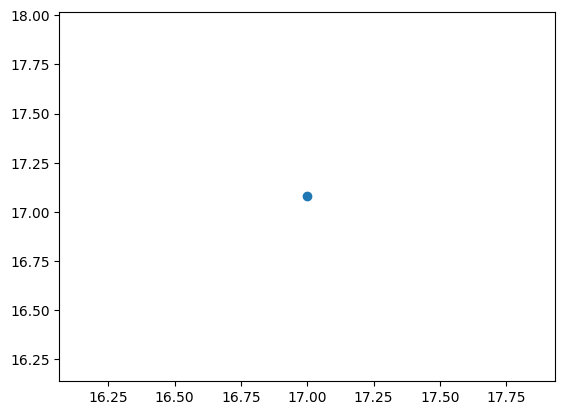

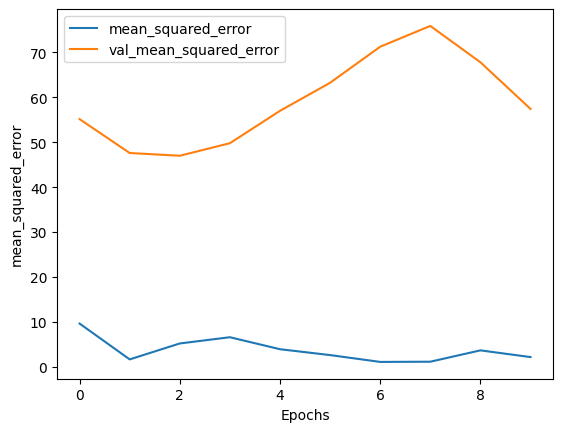

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.3347 - mean_squared_error: 1.3347 - val_loss: 44.5908 - val_mean_squared_error: 44.5908
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 5.6675 - mean_squared_error: 5.6675 - val_loss: 48.5995 - val_mean_squared_error: 48.5995
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 1.8730 - mean_squared_error: 1.8730 - val_loss: 67.1453 - val_mean_squared_error: 67.1453
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 1.9742 - mean_squared_error: 1.9742 - val_loss: 72.0658 - val_mean_squared_error: 72.0658
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 1.7054 - mean_squared_error: 1.7054 - val_loss: 65.6196 - val_mean_squared_error: 65.6196
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 1.0568 - mean_squared_error: 1.0568 - val_loss: 56.4548 - val_mean_squared_error: 56.4548
Epoch 7/10
1/1 [====================

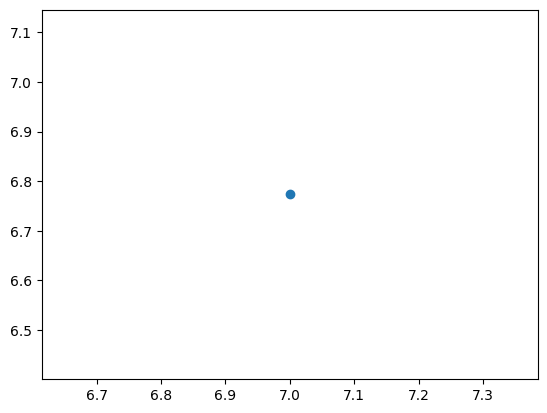

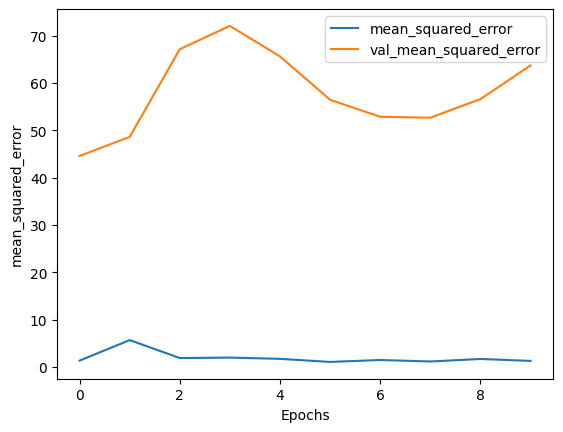

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.5596 - mean_squared_error: 0.5596 - val_loss: 105.3027 - val_mean_squared_error: 105.3027
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 6.8231 - mean_squared_error: 6.8231 - val_loss: 62.1114 - val_mean_squared_error: 62.1114
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.8781 - mean_squared_error: 0.8781 - val_loss: 46.6701 - val_mean_squared_error: 46.6701
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 4.1485 - mean_squared_error: 4.1485 - val_loss: 46.0236 - val_mean_squared_error: 46.0236
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 3.7447 - mean_squared_error: 3.7447 - val_loss: 47.8133 - val_mean_squared_error: 47.8133
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 2.1781 - mean_squared_error: 2.1781 - val_loss: 51.3476 - val_mean_squared_error: 51.3476
Epoch 7/10
1/1 [==================

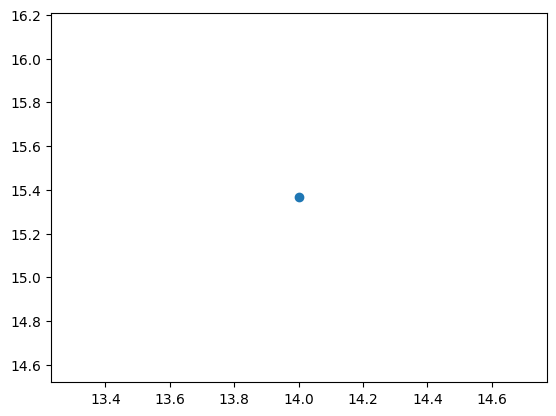

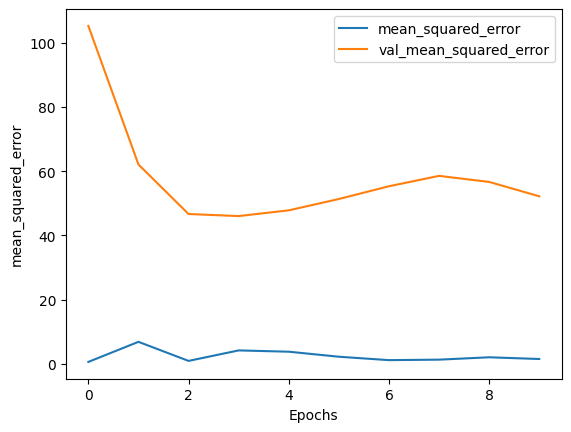

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.3749 - mean_squared_error: 1.3749 - val_loss: 45.1784 - val_mean_squared_error: 45.1784
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 3.5938 - mean_squared_error: 3.5938 - val_loss: 46.9430 - val_mean_squared_error: 46.9430
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.8683 - mean_squared_error: 1.8683 - val_loss: 54.3907 - val_mean_squared_error: 54.3907
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 1.7929 - mean_squared_error: 1.7929 - val_loss: 57.8840 - val_mean_squared_error: 57.8840
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 1.2275 - mean_squared_error: 1.2275 - val_loss: 55.6481 - val_mean_squared_error: 55.6481
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 1.5801 - mean_squared_error: 1.5801 - val_loss: 52.9427 - val_mean_squared_error: 52.9427
Epoch 7/10
1/1 [====================

KeyboardInterrupt: ignored

In [ ]:
# separar as features
X = features_importantes.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# criar um objeto LeaveOneOut
loo = LeaveOneOut()


for i in targets.columns[1:]:
  list_y_test = []
  list_y_pred = []
  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]


      """
      Standard Scale test and train data
      Z - Score normalization
      """

      # loss function
      msle = MeanSquaredError()
      model.compile(
          loss=msle,
          optimizer=Adam(learning_rate=learning_rate),
          metrics=[msle]
      )
      # train the model
      history = model.fit(
          X_train,
          y_train,
          epochs=10,
          batch_size=64,
          validation_split=0.2
      )

      y_test_predict = model.predict(X_test)
      plt.scatter(y_test,y_test_predict)
      plt.show()
      # Plot the history
      plot_history(history, 'mean_squared_error')




  # calcular o erro relativo absoluto (RAE) e adiciona na lista
  #media_rae.append(mean_absolute_error(list_y_test, list_y_pred[0]) / np.mean(list_y_test))
  # calcular o erro absoluto medio (MAE) e adiciona na lista
  #media_mae.append(mean_absolute_error(list_y_test, list_y_pred))
  # calcular R2 e adiciona na lista
  #media_r2.append(r2_score(list_y_test,list_y_pred))
  #tipo de ocorrencia
  #ocorrencias.append(i)
  #break

# metricas["Ocorrencia"] = ocorrencias
# metricas["RAE"] = media_rae
# metricas["MAE"] = media_mae
# metricas["R2"] = media_r2


In [ ]:
metricas

In [ ]:
metricas.to_csv("/content/drive/MyDrive/courb2/CSVs/metricas_82areas_ANN_POIs_users_newagroup22a23")

## modelos com métricas por área

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_features_users_mais_100_e_POIs2022a2023.csv")
features.drop(columns=["Unnamed: 0", "qtd_users"], inplace=True)
# features.head()

In [ ]:
targets = pd.read_csv("/content/drive/MyDrive/courb2/CSVs/dataset_soma_ocorr_mais_100_users_2022a2023.csv")

targets = targets.drop(columns=["Unnamed: 0","Unnamed: 0.1", "qtd_users"])

# targets.head()

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# separar as features
X = features.values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### RandomForest

In [ ]:
# criar um objeto do modelo Random Forest Regressor
model = RandomForestRegressor()

# criar um objeto LeaveOneOut
loo = LeaveOneOut()


data = pd.DataFrame(columns=['crime','area','mae', 'rae'])
cont = 0
for i in targets.columns[1:]:

  # separa a variável target
  #features[i] = targets[i]
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)


      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)


      results_rae = abs((y_test[0] - y_pred[0]) / y_test[0])
      results_mae = abs(y_test[0] - y_pred[0])

      data.loc[cont] = [i, test_index[0], results_mae, results_rae]

      cont+=1




KeyboardInterrupt: ignored

In [ ]:
data.to_csv("/content/drive/MyDrive/courb2/metricas_por_areaRF22a23.csv")

### SVM

In [ ]:
# criar modelo SVM
model = SVR(kernel='linear')

# normalização min-max
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

# normalização z-score
# scaler_zscore = StandardScaler()
# X_zscore = scaler_zscore.fit_transform(X)

# criar um objeto LeaveOneOut
loo = LeaveOneOut()

data = pd.DataFrame(columns=['crime','area','mae', 'rae'])
cont = 0

for i in targets.columns[1:]:

  # separa a variável target
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X_minmax):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)

      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)

      results_rae = abs((y_test[0] - y_pred[0]) / y_test[0])
      results_mae = abs(y_test[0] - y_pred[0])

      data.loc[cont] = [i, test_index[0], results_mae, results_rae]

      cont+=1



In [ ]:
data.to_csv("/content/drive/MyDrive/courb2/metricas_por_areaSVM22a23.csv")

### LinearRegression

In [ ]:
# criar um objeto do modelo Random Forest Regressor
model = LinearRegression()

# criar um objeto LeaveOneOut
loo = LeaveOneOut()


data = pd.DataFrame(columns=['crime','area','mae', 'rae'])
cont = 0
for i in targets.columns[1:]:

  # separa a variável target
  #features[i] = targets[i]
  y = targets[i].values


  # percorrer cada amostra do conjunto de dados
  for train_index, test_index in loo.split(X):

      # separar os conjuntos de treinamento e teste
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # treinar o modelo
      model.fit(X_train, y_train)


      # fazer a previsão usando o conjunto de teste
      y_pred = model.predict(X_test)


      results_rae = abs((y_test[0] - y_pred[0]) / y_test[0])
      results_mae = abs(y_test[0] - y_pred[0])

      data.loc[cont] = [i, test_index[0], results_mae, results_rae]

      cont+=1



In [ ]:
data.to_csv("/content/drive/MyDrive/courb2/metricas_por_areaLR22a23.csv")